# **Реализация системы извлечения изображений по текстовому описанию и поиск похожих фотографий**

**Цель работы:** разработка демонстрационной версии поиска изображений по запросу.

**Задача работы:** для демонстрационной версии требуется обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

**Дано:** 
1. `train_dataset.csv` содержит информация, необходимая для обучения: 
    - имя файла изображения;
    - идентификатор описания;
    - текст описания.
2. Папка `train_images` содержит изображения для тренировки модели.
3. `CrowdAnnotations.tsv` содержит данные по соответствию изображения и описания, полученные с помощью краудсорсинга:
    - Имя файла изображения;
    - Идентификатор описания;
    - Доля людей, подтвердивших, что описание соответствует изображению;
    - Количество человек, подтвердивших, что описание соответствует изображению;
    - Количество человек, подтвердивших, что описание не соответствует изображению.
4. `ExpertAnnotations.tsv` содержит данные по соответствию изображения и описания, полученные в результате опроса экспертов. Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.
    - Имя файла изображения;
    - Идентификатор описания;
    - 3, 4, 5 — оценки трёх экспертов.
5. `test_queries.csv` содержит информацию, необходимую для тестирования:
    - идентификатор запроса;
    - текст запроса;
    - релевантное изображение.
6. Папка `test_images` содержит изображения для тестирования модели.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import scipy.stats as st
import optuna
import random

import zipfile
import requests
import io
import os

import torch
import torch.nn as nn
import torchvision.models as models
import torch.utils.data as data_utils

from torchvision import transforms
from transformers import DebertaTokenizer, DebertaModel

from PIL import Image
from tqdm import notebook
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GroupShuffleSplit
from optuna.samplers import TPESampler
from optuna.pruners import SuccessiveHalvingPruner

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 73
random.seed(RANDOM_STATE)

## 1. Исследовательский анализ данных

In [2]:
# Офлайн/онлайн загрузка исследуемых данных
pth = './data/dsplus_integrated_project_4.zip'
url = None

if os.path.exists(pth):
    z = zipfile.ZipFile(pth, 'r')
elif requests.get(url).status_code == 200:
    z = zipfile.ZipFile(io.BytesIO(requests.get(url).content), 'r')
else:
    print('Проверь подключение к глобальной сети!')

train_dataset = pd.read_csv(z.open('to_upload/train_dataset.csv')).sort_values(by=['image','query_id'])

crowd_annot = pd.read_csv(
    z.open('to_upload/CrowdAnnotations.tsv'), sep='\t', names=['image','query_id','portion','num_pos','num_neg']
).sort_values(by=['image','query_id'])

expert_annot = pd.read_csv(
    z.open('to_upload/ExpertAnnotations.tsv'), sep='\t', names=['image','query_id','estim_1','estim_2','estim_3']
).sort_values(by=['image','query_id'])

display(train_dataset.head(3))
display(crowd_annot.head(3))
display(expert_annot.head(3))

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
12,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,A girl wearing a yellow shirt and sunglasses s...
22,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .


,image,query_id,portion,num_pos,num_neg
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3


,image,query_id,estim_1,estim_2,estim_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2


In [3]:
for i in [train_dataset,crowd_annot,expert_annot]:
    i.info()
    print('-'*40)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5822 entries, 0 to 1865
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 181.9+ KB
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   image     47830 non-null  object 
 1   query_id  47830 non-null  object 
 2   portion   47830 non-null  float64
 3   num_pos   47830 non-null  int64  
 4   num_neg   47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 2.2+ MB
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Nu

In [4]:
print('Количество дубликатов в таблице \'train_dataset\' =', train_dataset[['image','query_id']].duplicated().sum())
print('Количество дубликатов в таблице \'crowd_annot\' =', crowd_annot[['image','query_id']].duplicated().sum())
print('Количество дубликатов в таблице \'expert_annot\' =', expert_annot[['image','query_id']].duplicated().sum())

Количество дубликатов в таблице 'train_dataset' = 0
Количество дубликатов в таблице 'crowd_annot' = 0
Количество дубликатов в таблице 'expert_annot' = 0


### 1.1 Исследование данных текстового описания

In [5]:
def bar_chart_show_(data,title,xaxis,yaxis,width=800,height=400):
    '''Функция построения столбчатой диаграммы с агрегацией признака'''
    bar_chart = go.Bar(
        x=data.value_counts().sort_index().index,
        y=data.value_counts().sort_index().values
    )
    layout = go.Layout(
        title=title,
        xaxis=dict(title=xaxis),
        yaxis=dict(title=yaxis),
        width=width, height=height
    )
    fig = go.Figure(data=[bar_chart], layout=layout)
    fig.show()

bar_chart_show_(
    data=train_dataset.image.value_counts(),
    title='Столбчатая диаграмма частот встречаемовти различных имён файлов изображений',
    xaxis='Частота встречаемости имени файла изображений',
    yaxis='Количество частот'
)
print('Количество уникальных значений признаков:', train_dataset.image.nunique())

Количество уникальных значений признаков: 1000


Данные представлены 1000 уникальными изображениями. Описание к каждому изображению давалось с частотой от 2 до 10 раз, формируя колокообразную форму распределение с пиком на частоте 6. Если предположить, что выборка случайная, абсолютно не ясно по какой причине частотное распределение не несёт равномерный характер.

In [6]:
bar_chart_show_(
    data=train_dataset.query_id.value_counts(),
    title='Столбчатая диаграмма частот встречаемовти различных описаний изображений',
    xaxis='Частота встречаемости описаний изображений',
    yaxis='Количество частот'
)
print(f'Количество уникальных значений признаков \'query_id\' и \'query_text\':, {train_dataset.query_id.nunique()} и {train_dataset.query_text.nunique()}')

Количество уникальных значений признаков 'query_id' и 'query_text':, 977 и 977


In [7]:
# Очистка текстового описания от точек в конце
def remove_last_two_symbols(text):
    '''Функция для удаления символов в конце текстовых строк'''
    if (text[-1] == '.') and (text[-2] == ' '):
        return text[:-2]
    elif (text[-1] == ',') and (text[-2] == ' '):
        return text[:-2]
    elif (text[-1] == '.') and (text[-2] != ' '):
        return text[:-1]
    else:
        return text

train_dataset['query_text'] = train_dataset['query_text'].apply(remove_last_two_symbols).str.lower()
train_dataset.head()

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,a young child is wearing blue goggles and sitt...
12,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,a girl wearing a yellow shirt and sunglasses s...
22,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,a man sleeps under a blanket on a city street
27,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,a woman plays with long red ribbons in an empt...
31,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,chinese market street in the winter time


Количество уникальных значений текстового описания изображений меньше количества уникальных изображений. В данных присутствуют от одного до 34 описаний на одно изображение.

### 1.2 Исследование распределений оценок экспертов

In [8]:
bar_chart_show_(
    data=expert_annot.image.value_counts(),
    title='Столбчатая диаграмма частот встречаемовти различных имён файлов изображений',
    xaxis='Частота встречаемости имени файла изображений',
    yaxis='Количество частот'
)
print('Количество уникальных значений признаков:', expert_annot.image.nunique())

Количество уникальных значений признаков: 1000


In [9]:
bar_chart_show_(
    data=expert_annot.query_id.value_counts(),
    title='Столбчатая диаграмма частот встречаемовти различных описаний изображений',
    xaxis='Частота встречаемости описаний изображений',
    yaxis='Количество частот'
)
print(f'Количество уникальных значений признаков \'query_id\':, {expert_annot.query_id.nunique()}')

Количество уникальных значений признаков 'query_id':, 977


In [10]:
bar_chart = []
for col in ['estim_1', 'estim_2', 'estim_3']:
    bar_chart.append(go.Bar(
        x=expert_annot[col].value_counts().sort_index().index,
        y=expert_annot[col].value_counts().sort_index().values,
        name=col
    ))
layout = go.Layout(
    title='Столбчатая диаграмма оценок экспертов по соответствию изображения и описания',
    xaxis=dict(title='Оценки экспертов'),
    yaxis=dict(title='Количество оценок'),
    width=800, height=400
)
fig = go.Figure(data=bar_chart, layout=layout)
fig.show()

Даже не прибигая к статистическим тестам видно, что оценки экспертов имеют заметные расхождения в оценках соответствию изображений и описания.

Периведём оценки экспертов к значениям вероятности соответствию изображения описанию, где:
- 1 соответствует вероятности 0
- 2 соответствует вероятности 1/3.0
- 3 соответствует вероятности 1/1.5
- 4 соответствует вероятности 1

In [11]:
# Получение коэффициентов для линейного преобразования
model = LinearRegression()
model.fit(
    np.array([3, 12]).reshape(-1, 1), # Минимальная и максимальная сумма оценок экспертов
    np.array([0, 1]) # Целевой диапазон распределения оценок экспертов
)
coef = model.coef_[0]
intercept = model.intercept_

print('Коэффициент:', coef)
print('Свободный член:', intercept)

expert_annot['probability'] = expert_annot[['estim_1', 'estim_2', 'estim_3']].apply(lambda x: np.sum(x) * coef + intercept, axis=1).astype(np.float16)
expert_annot.head()

Коэффициент: 0.11111111111111109
Свободный член: -0.33333333333333315


,image,query_id,estim_1,estim_2,estim_3,probability
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1,0.000000
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,0.111084
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2,0.111084
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2,0.222168
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2,0.111084


In [12]:
# Расчёт суммы неопределённости ответов экспертов
def amount_of_uncertainty_(value):
    value_1 = abs(value[0] - value[1]) + abs(value[0] - value[2])
    value_2 = abs(value[1] - value[0]) + abs(value[1] - value[2])
    value_3 = abs(value[2] - value[0]) + abs(value[2] - value[1])
    return value_1 + value_2 + value_3

expert_annot['uncertainty'] = [amount_of_uncertainty_(i) for i in expert_annot[['estim_1', 'estim_2', 'estim_3']].values]
expert_annot['uncertainty'].value_counts()

0     3391
4     2272
8      156
12       3
Name: uncertainty, dtype: int64

Для анализа насколько сильно разнятся мнения экспертов, рассчитана сумма неопределённости ответов, полученной путём суммирования модулей разности балов ответов экспертов каждого друг с другом. Результаты показывают, что 58% мнений экспертов совпадают, ещё 39% различаются очень слабо и всего 2,7% отличаются значительно. Таким образом 2,7% данных можно отфильтровать, повысив точность оценки обучающей выборки.

In [13]:
# Очистка данных от ответов с высокой неопределённостью
expert_annot = expert_annot[expert_annot.uncertainty < 8]
expert_annot['uncertainty'].value_counts()

0    3391
4    2272
Name: uncertainty, dtype: int64

### 1.3 Исследование распределений оценок краудсорсинга

In [14]:
bar_chart_show_(
    data=crowd_annot.image.value_counts(),
    title='Столбчатая диаграмма частот встречаемовти различных имён файлов изображений',
    xaxis='Частота встречаемости имени файла изображений',
    yaxis='Количество частот'
)
print('Количество уникальных значений признаков:', crowd_annot.image.nunique())

Количество уникальных значений признаков: 1000


In [15]:
bar_chart_show_(
    data=crowd_annot.query_id.value_counts(),
    title='Столбчатая диаграмма частот встречаемовти различных описаний изображений',
    xaxis='Частота встречаемости описаний изображений',
    yaxis='Количество частот'
)
print(f'Количество уникальных значений признаков \'query_id\':, {crowd_annot.query_id.nunique()}')

Количество уникальных значений признаков 'query_id':, 1000


In [16]:
bar_chart = go.Bar(
    x=crowd_annot['portion'].value_counts().sort_index().index,
    y=crowd_annot['portion'].value_counts().sort_index().values)
layout = go.Layout(
    title='Столбчатая диаграмма частот вероятностей соответствия описания изображению',
    xaxis=dict(title='Оценка вероятности'),
    yaxis=dict(title='Частота оценок'))
fig = go.Figure(data=[bar_chart], layout=layout)
fig.show()

Основная доля оценок (87,7%) отнесена к негативному классу, так же таблица оценок краудсорсинга содержит большее количество идентификаторов описаний изображений, нежели в тестовом наборе данных.

## 2. Проверка данных

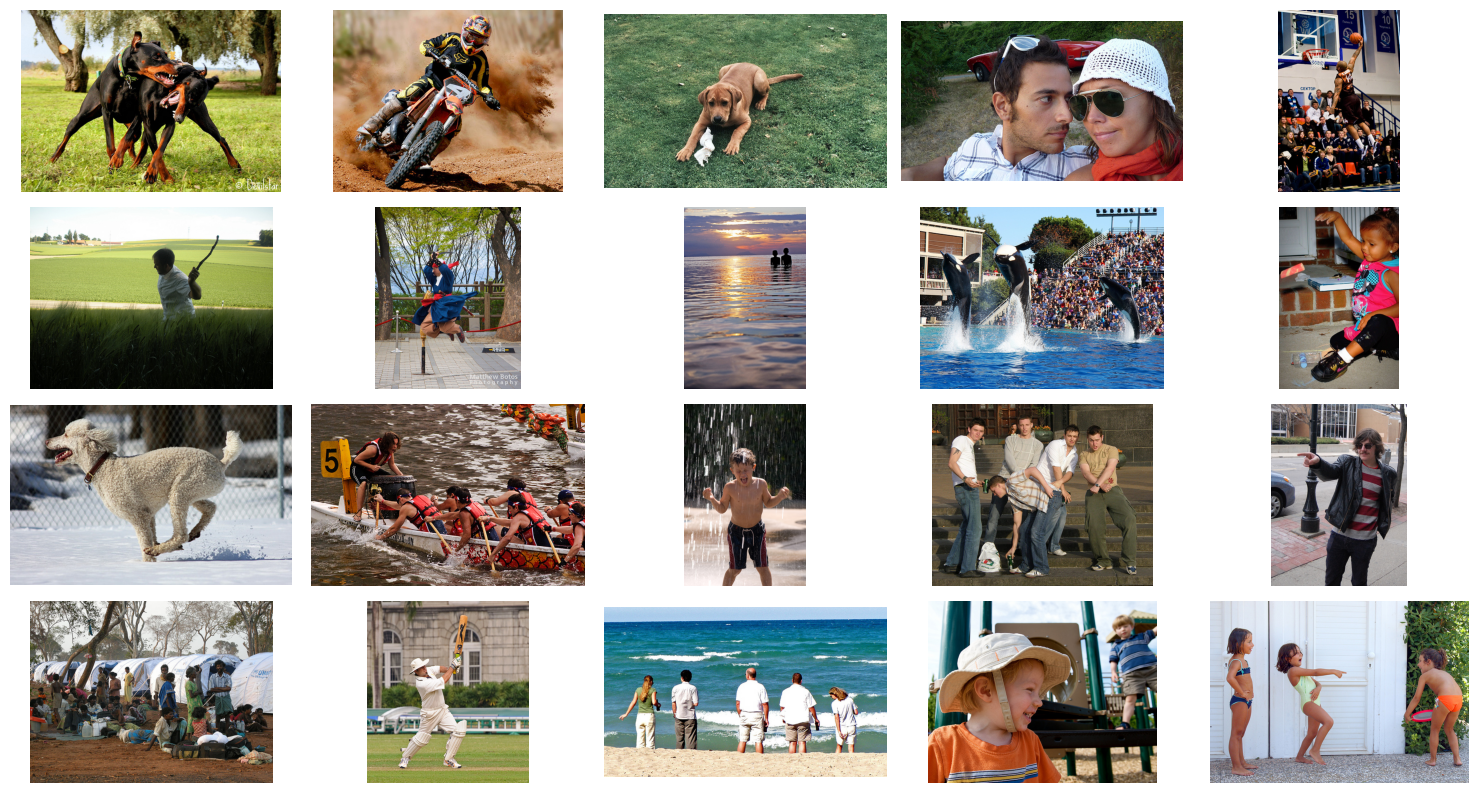

In [17]:
# Загрузка изображений
# Фильтруем список файлов, чтобы оставить только изображения из нужной папки
images = [file for file in z.namelist() if file.startswith('to_upload/train_images/') and file.endswith('.jpg')]

fig = plt.figure(figsize=(15,10))
for i, image_file in enumerate(images[0:20]): # Открываем изображения
    image = Image.open(io.BytesIO(z.open(image_file).read()))
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(image)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [18]:
# Список индексов описаний изображений, не содержащих запрещённых слов
filtr_words = ['child','boy','boys','kid','kids','girl','girls','baby','naked','toddler','babies','youths']
filtr_query_id = train_dataset[~train_dataset.query_text.str.contains('|'.join(filtr_words))].query_id.unique()

# Фильтруем данные с оценками
print('Размер набора данных до фильтрации', crowd_annot.shape, expert_annot.shape)
crowd_annot = crowd_annot[crowd_annot.query_id.isin(filtr_query_id)]
expert_annot = expert_annot[expert_annot.query_id.isin(filtr_query_id)]
print('Размер набора данных после фильтрации', crowd_annot.shape, expert_annot.shape)

Размер набора данных до фильтрации (47830, 5) (5663, 7)
Размер набора данных после фильтрации (33228, 5) (4104, 7)


Набор изображений содержит большое количество изображений детей. По условию задания выпонено удаление запросов, имеющих отношение к детям, таким образом сокращается размер данных, полученных от экспертов, на 27,5%, а данных от краудсорсинга на 30,5%.

## 3. Векторизация изображений

In [19]:
# Нормализация и предварительная обработка
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# Загрузка модели
model_transf = models.googlenet(pretrained=True)
for param in model_transf.parameters(): # Замарозка весов
    param.requires_grad_(False)
model_transf = nn.Sequential(*list(model_transf.children())[:-1])

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_transf.to(device).eval()

# Получение имён изображений
images = [file for file in z.namelist() if file.startswith('to_upload/train_images/') and file.endswith('.jpg')]

batch_size = 100
img_embed = [] # Ембединги изображений
name_images = [text[23:] for text in images] # Список имён обработанных изображений

# Получение ембедингов изображений
for i in notebook.tqdm(range(0, len(images), batch_size)):
    batch = [Image.open(io.BytesIO(z.open(file).read())).convert('RGB') for file in images[i:i+batch_size]]
    tensor = torch.stack([transform(image).to(device) for image in batch]) # Обработка и обьединение в один тензор
    
    with torch.no_grad():
        output = model_transf(tensor).cpu()
        img_embed.extend(output.view(output.size(0), -1).detach().numpy()) # Изменение формы и отсоединение тензоров

np.array(img_embed).shape

  0%|          | 0/10 [00:00<?, ?it/s]

(1000, 1024)

Для векторизации изображений были рассмотренны следующие предобученные модели: ResNet, RegNet, ResNeXt, DenseNet, GoogLeNet. На безлайновой линейной модели относительно хорошую метрику и очень высокую скорость работы показала модель googlenet, формируя относительно небольшое количество значений вектора, равного 1024. Замеченно, что модели с большим числом параметров показывают заметно более слабый результат, что, возможно, обьесняется малым обьёмом данных.

## 4. Векторизация текстов

In [20]:
# Таблица с уникальными значениями текстового описания
df_text = train_dataset.drop(['image'],axis=1).drop_duplicates()

# Инициализация токенизатора и модели
tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')
model_tokeniz = DebertaModel.from_pretrained('microsoft/deberta-base')
model_tokeniz.to(device)

batch_size = 100
name_texts = df_text.query_id.to_list() # Список имён обработанных текстов
text_embed = [] # Ембединги текстов

# Получение ембедингов текста
for i in notebook.tqdm(range(0, len(df_text), batch_size)):
    batch = [file for file in df_text.query_text[i:i+batch_size]]
    inputs = tokenizer(
        batch, 
        add_special_tokens=True,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors='pt'
    ).to(device)
    
    with torch.no_grad(): # Получение эмбеддингов
        output = model_tokeniz(**inputs).last_hidden_state.mean(dim=1).cpu()

    text_embed.extend(output.view(output.size(0), -1).detach().numpy()) # Изменение формы и отсоединение тензоров

np.array(text_embed).shape

  0%|          | 0/10 [00:00<?, ?it/s]

(977, 768)

Для векторизации текстов были рассмотрены следующие предобученные модели: bert-base/large, roberts-base/large, electra-base/large, deberta-base/large. На безлайновой линейной модели относительно хорошую метрику и очень высокую скорость работы показала модель deberta-base, формируя относительно небольшое количество значений вектора, равного 768. По аналогии с получением векторов изображений, так же замечено, что модели с большим числом параметров показывают заметно более слабый результат, что, возможно, объясняется малым объёмом данных.

## 5. Объединение векторов

In [21]:
def building_feature_matrix_(data_X, data_Y=None):
    '''Функция построения матрицы ембедингов'''
    X = []
    for i, t in zip(data_X.image, data_X.query_id):
        img = img_embed[name_images.index(i)]
        text = text_embed[name_texts.index(t)]
        X.append(np.concatenate((img, text)))

    return np.ascontiguousarray(X), np.ascontiguousarray(data_Y)

def combine_and_fill(row, alfa):
    '''Функция для объединения portion и probability'''
    if not pd.isna(row['portion']):
        return row['portion']
    elif not pd.isna(row['probability']):
        return row['probability']
    else:
        return row['portion'] * (1 - alfa) + row['probability'] * alfa
  
def preparing_dataframe_configuration_(proportion_zero, weight_expert_asses):
    '''Функция для создания объединённого DataFrame на основе заданного веса экспертных оцеток и
    заданной доли негативных отметок краутсорсинговых данных'''
    # Создаём маску для оптимизации количества негативных сценарием соответствия содержания для crowd_annot
    mask = (crowd_annot['portion'] == 0) & np.random.choice([True, False], crowd_annot.shape[0], p=[proportion_zero, 1-proportion_zero])
    crowd_annot_dubl = crowd_annot.copy(deep=True)
    crowd_annot_dubl.loc[mask, 'portion'] = np.nan

    # Создание объединённого датафрейма, с учётом подобранных условий
    crowd_expert_df = pd.merge(crowd_annot_dubl.dropna(), expert_annot, on=['image', 'query_id'], how='outer')
    crowd_expert_df = crowd_expert_df[['image', 'query_id', 'portion', 'probability']]
    crowd_expert_df['estimation'] = crowd_expert_df.apply(combine_and_fill, args=(weight_expert_asses,), axis=1)

    X, Y, group = crowd_expert_df[['image','query_id']], crowd_expert_df.estimation, crowd_expert_df.image

    return X, Y, group

Данные, полученные в ходе экспертных оценок, обладают приоритетной значимость, поэтому они остаются в полном объёме. Данные, полученные с краутсорсинга, имеют огромную долю негативных оценок, которые в таком количестве не несут положительной нагрузки, в следствии чего решено использовать возможность сокращения размера данных за счёт снижения их количества. Так же одинаковые оценки экспертов и краутсорсинга решено объединить, в соотношении, который будет подобран с использованием возможностей фреймворка Optuna. Так же данный фреймворк будет подбирать оптимальную долю негативных оценок краутсорсингового набора данных.

## 6. Обучение модели предсказания соответствия

Для оптимизации гиперпараметров выбрана метрика RMSE, поскольку она хорошо подходит для непрерывного ряда, а также она сильно чувствительна к выбросам, то есть значительно сильней реагирует на краевые значения.

In [22]:
# Подбор оптимальных гиперпараметров для Ridge
TUNE_HYPERPARAMETERS = False
if TUNE_HYPERPARAMETERS:
    def objective(trial: optuna.Trial):
        X, Y, group = preparing_dataframe_configuration_(
            trial.suggest_float('proportion_zero', 0, 1), # Доля нулевых вероятностей
            trial.suggest_float('weight_expert_asses', 0, 1), # Вес экспертных оценок
        )
        try:
            scores = []
            gss = GroupShuffleSplit(n_splits=5, train_size=.7, random_state=RANDOM_STATE)
            for train_ind, test_ind in gss.split(X, Y, group):
                X_train, Y_train = building_feature_matrix_(X.iloc[train_ind], Y.iloc[train_ind])
                X_test, Y_test = building_feature_matrix_(X.iloc[test_ind], Y.iloc[test_ind])

                scaler = StandardScaler().fit(X_train)
                X_train = scaler.transform(X_train)
                X_test = scaler.transform(X_test)

                if trial.suggest_categorical('iter', [True, False]):
                    max_iter = trial.suggest_int('max_iter', 100, 1000)
                else:
                    max_iter = None

                model = Ridge(
                    random_state=RANDOM_STATE, 
                    max_iter=max_iter,
                    alpha=trial.suggest_float('alpha', 0.1, 10),
                    fit_intercept=trial.suggest_categorical('fit_intercept', [True, False]),
                    solver=trial.suggest_categorical('solver', ['auto','svd','cholesky','lsqr','sparse_cg','sag','saga']),
                    tol=trial.suggest_float('tol', 1e-4, 1e-3),
                )
                model.fit(X_train, Y_train)
                pred = model.predict(X_test)
                scores.append(np.sqrt(mean_absolute_error(Y_test, pred)))

            return st.t.interval(confidence=0.95, df=(len(scores) - 1), loc=np.mean(scores), scale=np.std(scores))[1]
        except:
            raise optuna.TrialPruned()
    
    study = optuna.create_study(direction='minimize', 
                                sampler=TPESampler(seed=RANDOM_STATE),
                                pruner=SuccessiveHalvingPruner(),
                                #study_name='Ridge', storage='sqlite:///my_study_Ridge.db', load_if_exists=True
                                )
    study.optimize(objective, n_trials=1, timeout=None, n_jobs=6)
else:
    print('''
    Количество завершенных испытаний: 200
    Лучшее испытание завершено на итерации: 147
    Лучшее значение целевой метрики: 0.37542015917509725
    ''')
    X, Y, group = preparing_dataframe_configuration_(0.00022673754443832555, 0.736065921475663)
    m_r = Ridge(
        random_state=RANDOM_STATE, 
        max_iter=949,
        alpha=5.979551300996067,
        fit_intercept=False,
        solver='lsqr',
        tol=0.0009968139197803348
    )
    scores = []
    gss = GroupShuffleSplit(n_splits=5, train_size=.7, random_state=RANDOM_STATE)
    for train_ind, test_ind in gss.split(X, Y, group):
        X_train, Y_train = building_feature_matrix_(X.iloc[train_ind], Y.iloc[train_ind])
        X_test, Y_test = building_feature_matrix_(X.iloc[test_ind], Y.iloc[test_ind])

        scaler = StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

        m_r.fit(X_train, Y_train)
        pred = m_r.predict(X_test)
        scores.append(np.sqrt(mean_absolute_error(Y_test, pred)))

print('RMSE:', np.mean(scores))


    Количество завершенных испытаний: 200
    Лучшее испытание завершено на итерации: 147
    Лучшее значение целевой метрики: 0.37542015917509725
    
RMSE: 0.3690035301213788


In [23]:
# Подбор оптимальных гиперпараметров для Lasso
TUNE_HYPERPARAMETERS = False
if TUNE_HYPERPARAMETERS:
    def objective(trial: optuna.Trial):
        X, Y, group = preparing_dataframe_configuration_(
            trial.suggest_float('proportion_zero', 0, 1), # Доля нулевых вероятностей
            trial.suggest_float('weight_expert_asses', 0, 1), # Вес экспертных оценок
        )
        try:
            scores = []
            gss = GroupShuffleSplit(n_splits=5, train_size=.7, random_state=RANDOM_STATE)
            for train_ind, test_ind in gss.split(X, Y, group):
                X_train, Y_train = building_feature_matrix_(X.iloc[train_ind], Y.iloc[train_ind])
                X_test, Y_test = building_feature_matrix_(X.iloc[test_ind], Y.iloc[test_ind])

                scaler = StandardScaler().fit(X_train)
                X_train = scaler.transform(X_train)
                X_test = scaler.transform(X_test)

                model = Lasso(
                    random_state=RANDOM_STATE, 
                    alpha=trial.suggest_float('alpha', 0.01, 100),
                    fit_intercept=trial.suggest_categorical('fit_intercept', [True, False]),
                    precompute=trial.suggest_categorical('precompute', [True, False]),
                    max_iter=trial.suggest_int('max_iter', 100, 10000),
                    tol=trial.suggest_float('tol', 1e-5, 1e-3),
                    warm_start=trial.suggest_categorical('warm_start', [True, False]),
                    positive=trial.suggest_categorical('positive', [True, False]),
                    selection=trial.suggest_categorical('selection', ['cyclic', 'random']),
                )
                model.fit(X_train, Y_train)
                pred = model.predict(X_test)
                scores.append(np.sqrt(mean_absolute_error(Y_test, pred)))

            return st.t.interval(confidence=0.95, df=(len(scores) - 1), loc=np.mean(scores), scale=np.std(scores))[1]
        except:
            raise optuna.TrialPruned()
    
    study = optuna.create_study(direction='minimize', 
                                sampler=TPESampler(seed=RANDOM_STATE),
                                pruner=SuccessiveHalvingPruner(),
                                #study_name='Lasso', storage='sqlite:///my_study_Lasso.db', load_if_exists=True
                                )
    study.optimize(objective, n_trials=1, timeout=None, n_jobs=4)
else:
    print('''
    Количество завершенных испытаний: 500
    Лучшее испытание завершено на итерации: 233
    Лучшее значение целевой метрики: 0.2976553580173821
    ''')
    X, Y, group = preparing_dataframe_configuration_(0.00038893315284006997, 0.10332125361971647)
    m_l = Lasso(
        random_state=RANDOM_STATE, 
        alpha=7.887299015759659,
        fit_intercept=False,
        precompute=False,
        max_iter=2056,
        tol=3.9721652054183496e-05,
        warm_start=False,
        positive=False,
        selection='cyclic'
    )
    scores = []
    gss = GroupShuffleSplit(n_splits=5, train_size=.7, random_state=RANDOM_STATE)
    for train_ind, test_ind in gss.split(X, Y, group):
        X_train, Y_train = building_feature_matrix_(X.iloc[train_ind], Y.iloc[train_ind])
        X_test, Y_test = building_feature_matrix_(X.iloc[test_ind], Y.iloc[test_ind])

        scaler = StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

        m_l.fit(X_train, Y_train)
        pred = m_l.predict(X_test)
        scores.append(np.sqrt(mean_absolute_error(Y_test, pred)))

print('RMSE:', np.mean(scores))


    Количество завершенных испытаний: 500
    Лучшее испытание завершено на итерации: 233
    Лучшее значение целевой метрики: 0.2976553580173821
    
RMSE: 0.28055465649010375


In [24]:
# Функции для работы полносвязной нейронной сети с использованием батчей
def building_nn_architecture_(list_neurons, activ_funct, last_af):
    '''Построение архитектуры нейронной сети'''
    net_layers = [] # Архетектура сети
    for i in range(1, len(list_neurons) - 1): # Создаём список с архитектурой сети
        net_layers.append(nn.Linear(list_neurons[i-1], list_neurons[i]))
        net_layers.append(activ_funct[i-1])
    net_layers.append(nn.Linear(list_neurons[-2], list_neurons[-1]))
    net_layers.append(last_af)
    return nn.Sequential(*net_layers) # Инициализируем MLP

def preparing_split_data_for_nn_model_batch_(data_x, data_y, train_ind, test_ind, batch_size):
    '''Функция подготавливает данные для каждого фолда цикла кросвалидации:
    формирует ембединги, нормализует и собирает в загрузчик для батчей'''
    X_train, Y_train = building_feature_matrix_(data_x.iloc[train_ind], data_y.iloc[train_ind])
    X_test, Y_test = building_feature_matrix_(data_x.iloc[test_ind], data_y.iloc[test_ind])

    scaler = StandardScaler().fit(X_train)
    X_train, Y_train = torch.FloatTensor(scaler.transform(X_train)), torch.FloatTensor(Y_train)
    X_test, Y_test = torch.FloatTensor(scaler.transform(X_test)), torch.FloatTensor(Y_test)

    train_loader = torch.utils.data.DataLoader(dataset=data_utils.TensorDataset(X_train, Y_train), batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(dataset=data_utils.TensorDataset(X_test, Y_test), batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

def taking_train_loss_on_batches_(model, train_loader, optimizer, loss):
    '''Получение значениия функции потерь на тренировочных данных с использованием батчей'''
    model.train()
    train_loss = 0
    for X_batch, Y_batch in train_loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        optimizer.zero_grad()
        train_preds = model.forward(X_batch).flatten()
        batch_loss = loss(train_preds, Y_batch)
        batch_loss.backward()
        optimizer.step()
        train_loss += batch_loss.item()
    train_loss /= len(train_loader)
    return train_loss

def taking_test_loss_on_batches_(model, test_loader, loss):
    '''Получение значениия функции потерь на тестовых данных с использованием батчей'''
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X_batch, Y_batch in test_loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            test_preds = model.forward(X_batch).flatten()
            batch_loss = loss(test_preds, Y_batch)
            test_loss += batch_loss.item()
    test_loss /= len(test_loader)
    return test_loss

a_f = {
    'sigmoid': nn.Sigmoid(),
    'relu': nn.ReLU(),
    'prelu': nn.PReLU(),
    'tanh': nn.Tanh(),
    'elu': nn.ELU(),
    'identity': nn.Identity(),
    'leaky_relu': nn.LeakyReLU(),
    'softplus': nn.Softplus(),
    'selu': nn.SELU()
}
list_fa = ['sigmoid','relu','prelu','tanh','elu','identity','leaky_relu','softplus','selu']

In [25]:
# Подбор архитектуры нейронной сети
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

TUNE_HYPERPARAMETERS = False
if TUNE_HYPERPARAMETERS:
    def objective(trial: optuna.Trial):
        
        num_epochs = 100 # Задаём количество эпох
        max_neurons = 1000 # Задаём максимальное значение количества нейронов в слое
        batch_size = trial.suggest_int('batch_siz', 256, 32768, step=8) # Задаём размер батчей

        X, Y, group = preparing_dataframe_configuration_(
            trial.suggest_float('proportion_zero', 0, 1), # Доля нулевых вероятностей краутсорсинговых данных
            trial.suggest_float('weight_expert_asses', 0, 1), # Вес экспертных оценок в общем датаврейме
        )
        scores = []
        epohs = []
        gss = GroupShuffleSplit(n_splits=5, train_size=.7, random_state=RANDOM_STATE)
        for train_ind, test_ind in gss.split(X, Y, group):
            train_loader, test_loader = preparing_split_data_for_nn_model_batch_(X, Y, train_ind, test_ind, batch_size)

            # Проектирование архитектуры нейросети
            n_layer = trial.suggest_int('n_layer', 1, 6, step=1) # Количество скрытых слоёв
            list_neurons = [X_train.shape[1]] # Список c количеством нейронов
            activ_funct = [] # Установка списка ФА для слоёв кроме последнего

            if n_layer >= 1: # Подбираем параметры сети под заданое количество скрытых слоёв
                list_neurons.append(trial.suggest_int('n_neurons_1', 1, max_neurons, step=10))
                activ_funct.append(a_f[trial.suggest_categorical('activ_funct_1', list_fa)])
                if n_layer >= 2:
                    list_neurons.append(trial.suggest_int('n_neurons_2', 1, max_neurons, step=10))
                    activ_funct.append(a_f[trial.suggest_categorical('activ_funct_2', list_fa)])
                    if n_layer >= 3:
                        list_neurons.append(trial.suggest_int('n_neurons_3', 1, max_neurons, step=10))
                        activ_funct.append(a_f[trial.suggest_categorical('activ_funct_3', list_fa)])
                        if n_layer >= 4:
                            list_neurons.append(trial.suggest_int('n_neurons_4', 1, max_neurons, step=10))
                            activ_funct.append(a_f[trial.suggest_categorical('activ_funct_4', list_fa)])
                            if n_layer >= 5:
                                list_neurons.append(trial.suggest_int('n_neurons_5', 1, max_neurons, step=10))
                                activ_funct.append(a_f[trial.suggest_categorical('activ_funct_5', list_fa)])
                                if n_layer >= 6:
                                    list_neurons.append(trial.suggest_int('n_neurons_6', 1, max_neurons, step=10))
                                    activ_funct.append(a_f[trial.suggest_categorical('activ_funct_6', list_fa)])
            list_neurons.append(1)

            nn_model = building_nn_architecture_(list_neurons, activ_funct, nn.Sigmoid()).to(device)
            loss = nn.MSELoss()
            optimizer = torch.optim.Adam(nn_model.parameters(), lr=trial.suggest_float('optimizer_Adam_ir', 0.00001, 0.01))

            loss_best = 1e100
            epohs_best = 0
            for n_epohs in range(num_epochs): # Обучение и тестирование модели
                train_loss = taking_train_loss_on_batches_(nn_model, train_loader, optimizer, loss)
                test_loss = taking_test_loss_on_batches_(nn_model, test_loader, loss)

                # Поиск оптимального значения функции потерь
                metric_loss = test_loss + abs(test_loss - train_loss)
                loss_best, epohs_best = (metric_loss, n_epohs) if metric_loss < loss_best else (loss_best, epohs_best)

            scores.append(np.sqrt(loss_best))
            epohs.append(epohs_best)

        trial.set_user_attr('epohs', [X.shape, epohs, scores])
        return np.mean(scores)
    
    def custom_callback(study: optuna.Study, trial: optuna.Trial):
        score = trial.user_attrs.get('epohs')
        if score is not None:
            print(f'Trial {trial.number}: epohs={score}')

    study = optuna.create_study(
        direction='minimize', 
        sampler=TPESampler(seed=RANDOM_STATE),
        #study_name='MLP_batch', storage='sqlite:///my_study_MLP_batch.db', load_if_exists=True
    )
    study.optimize(objective, n_trials=1, timeout=None, n_jobs=1, callbacks=[custom_callback])
else:
    print('''
    Количество завершенных испытаний: 228
    Лучшее испытание завершено на итерации: 184
    Лучшее значение целевой метрики: 0.1740916963765656
    ''')

cuda

    Количество завершенных испытаний: 228
    Лучшее испытание завершено на итерации: 184
    Лучшее значение целевой метрики: 0.1740916963765656
    


In [26]:
# Валидация архитектуры нейронной сети
X, Y, group = preparing_dataframe_configuration_(0.0590529337984408, 0.5772626045211601)

# Формируем DataFrame с результатами изменений функции потерь по эпохам
scores_train = pd.DataFrame(columns=['split_1','split_2','split_3','split_4','split_5'])
scores_test = pd.DataFrame(columns=['split_1','split_2','split_3','split_4','split_5'])

gss = GroupShuffleSplit(n_splits=10, train_size=.7, random_state=RANDOM_STATE) # Обучение и тестирование нейросети
for (train_ind, test_ind), split in zip(gss.split(X, Y, group), scores_train.columns):
    train_loader, test_loader = preparing_split_data_for_nn_model_batch_(X, Y, train_ind, test_ind, 9632)

    # Создание архитектуры нейросети
    list_neurons = [X_train.shape[1], 941, 451, 691, 1]
    activ_funct = [nn.Softplus(), nn.ELU(), nn.Sigmoid()]
    nn_model = building_nn_architecture_(list_neurons, activ_funct, nn.Sigmoid()).to(device)
    loss = nn.MSELoss()
    optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.0011294510617478135)

    for n_epohs in range(35): # Обучение и тестирование нейронной сети
        train_loss = taking_train_loss_on_batches_(nn_model, train_loader, optimizer, loss)
        test_loss = taking_test_loss_on_batches_(nn_model, test_loader, loss)

        scores_train.loc[n_epohs, split] = np.sqrt(train_loss)
        scores_test.loc[n_epohs, split] = np.sqrt(test_loss)

scores_train['mean'] = scores_train.mean(axis=1)
scores_test['mean'] = scores_test.mean(axis=1)

fig = go.Figure() # График обучения нейронной сети
fig.add_trace(go.Scatter(x=scores_train.index, y=scores_train['mean'], mode='lines', name='RMSE for train'))
fig.add_trace(go.Scatter(x=scores_test.index, y=scores_test['mean'], mode='lines', name='RMSE for test'))
fig.update_layout(
title='График изменения значения функции потерь по эпохам',
xaxis_title='Эпоха', yaxis_title='sqrt(MSELoss)'
)
fig.show()

print('Оптимальное значение RMSE(test/train)=0.18/0.18, на эпохе 35')

Оптимальное значение RMSE(test/train)=0.18/0.18, на эпохе 35


Обучены и подобраны гиперпараметры для трёх моделей, результаты приведены в сводной таблице:

| Модели                     | RMSE   | Испытаний | Лучшее испытание |
| -------------------------- | ------ | --------- | ---------------- |
| Ridge                      | 0.369  | 200       | 147              |
| Lasso                      | 0.281  | 500       | 233              |
| NeuralNetworkModel         | 0.180  | 228       | 184              |

Смоделированная полносвязная нейронная сеть показывает лучший результат, уже в среднем на 35 эпохах, можно ожидать целевую метрику RMSE в районе 0.18. Отметим что при длительном обучении сети происходит незначительное увеличение целевой метрики на тестовых данных до 0,20, при том, то модель практически полностью подстраивается под тренировочный набор RMSE=0.02. Возможно данное поведение может свидетельствовать о недостаточном объёме данных, в следствии чего нейронная сеть способно со временем подстраиваться под тестовый набор данных (график ниже), но это не точно))).

[![imag](https://sun9-20.userapi.com/impg/kg1Y6i7BeLdD8RTd5U8ZQUcRYlFWJ5SkWQPi7A/dyn-c0h5iNE.jpg?size=1778x450&quality=95&sign=bd7c6c284e47ccec76580535c4225a3c&type=album)]()

### 6.1 Обучение лучшей модели на всех данных

In [27]:
# Подготовка данных для обучения модели
X_train, Y_train, group = preparing_dataframe_configuration_(0.0590529337984408, 0.5772626045211601)
X_train, Y_train = building_feature_matrix_(X_train, Y_train)

scaler = StandardScaler().fit(X_train)
X_train, Y_train = torch.FloatTensor(scaler.transform(np.ascontiguousarray(X_train))), torch.FloatTensor(Y_train)

print(X_train.shape, Y_train.shape)

# Обучение модели
train_loader = torch.utils.data.DataLoader(dataset=data_utils.TensorDataset(X_train, Y_train), batch_size=9632, shuffle=False)

list_neurons = [X_train.shape[1], 941, 451, 691, 1]
activ_funct = [nn.Softplus(), nn.ELU(), nn.Sigmoid()]
nn_model = building_nn_architecture_(list_neurons, activ_funct, nn.Sigmoid()).to(device)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.0011294510617478135)

train_loss_list = []
for n_epohs in notebook.tqdm(range(35)): # Количество эпох
    nn_model.train()
    train_loss = 0
    for X_batch, Y_batch in train_loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        optimizer.zero_grad()
        train_preds = nn_model.forward(X_batch).flatten()
        batch_loss = loss(train_preds, Y_batch)
        batch_loss.backward()
        optimizer.step()
        train_loss += batch_loss.item()
    train_loss /= len(train_loader)

    train_loss_list.append(np.sqrt(train_loss))

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(len(train_loss_list)+1)), y=train_loss_list, mode='lines', name='RMSE for train'))
fig.update_layout(
    title='График изменения значения функции потерь по эпохам',
    xaxis_title='Эпоха', yaxis_title='sqrt(MSELoss)'
)
fig.show()

torch.Size([33990, 1792]) torch.Size([33990])


  0%|          | 0/35 [00:00<?, ?it/s]

Обучение нейросети на полном объёме данных показал схожую метрику RMSE, полученную на кросвалидации 0.18.

## 7. Тестирование модели

In [28]:
# Загрузка данных
test_images = pd.read_csv(z.open('to_upload/test_images.csv'))
test_queries = pd.read_csv(z.open('to_upload/test_queries.csv'), sep='|').drop('Unnamed: 0', axis=1)

print('Количество дубликатов в таблице \'test_images\' =', test_images.duplicated().sum())
print('Количество дубликатов в таблице \'test_queries\' =', test_queries[['image','query_id']].duplicated().sum())

# Очистка текстового описания от точек в конце и приведение к нижнему регистру
test_queries['query_text'] = test_queries['query_text'].apply(remove_last_two_symbols).str.lower()

display(test_images.head(3))
display(test_queries.head(3))

print('Размеры датафреймов', test_images.shape, test_queries.shape)

Количество дубликатов в таблице 'test_images' = 0
Количество дубликатов в таблице 'test_queries' = 0


,image
0,3356748019_2251399314.jpg
1,2887171449_f54a2b9f39.jpg
2,3089107423_81a24eaf18.jpg


,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,two boys are squirting water guns at each other,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,two boys spraying each other with water,1177994172_10d143cb8d.jpg


Размеры датафреймов (100, 1) (500, 3)


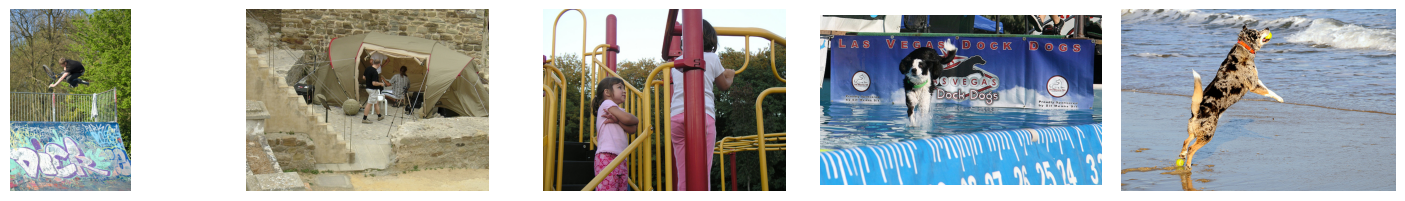

In [29]:
# Загрузка изображений
images = [file for file in z.namelist() if file.startswith('to_upload/test_images/') and file.endswith('.jpg')]
fig = plt.figure(figsize=(15,10))
for i, image_file in enumerate(images[0:5]): # Открываем изображения
    image = Image.open(io.BytesIO(z.open(image_file).read()))
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(image)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [30]:
# Обработка изображений
batch_size = 10
img_embed_test = [] # Ембединги изображений
name_images_test = [text[22:] for text in images] # Список имён обработанных изображений

# Получение ембедингов изображений
for i in notebook.tqdm(range(0, len(images), batch_size)):
    batch = [Image.open(io.BytesIO(z.open(file).read())).convert('RGB') for file in images[i:i+batch_size]]
    tensor = torch.stack([transform(image).to(device) for image in batch]) # Обработка и обьединение в один тензор
    
    with torch.no_grad():
        output = model_transf(tensor).cpu()
        img_embed_test.extend(output.view(output.size(0), -1).detach().numpy()) # Изменение формы и отсоединение тензоров

np.array(img_embed_test).shape

  0%|          | 0/10 [00:00<?, ?it/s]

(100, 1024)

In [31]:
def model_testing_function_(text):
        # Фильтрация недопустимых запросов
    if any(word in text for word in filtr_words):
        return print('WARNING! This image is unavailable in your country in compliance with local laws.\n','-'*100)
    else:
        # Получение ембедингов текста
        inputs = tokenizer(
            text, 
            add_special_tokens=True,
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors='pt'
        ).to(device)
            
        with torch.no_grad():
            text_embed = model_tokeniz(**inputs).last_hidden_state.mean(dim=1).cpu().numpy()[0]

        embed_pocket = [] # Ембединги одного запроса со всеми изображениями
        for i in name_images_test:
            embed_pocket.append(np.concatenate((
                img_embed_test[name_images_test.index(i)], 
                text_embed
            )))
        # Получение предсказаний
        embed_pocket = torch.FloatTensor(scaler.transform(np.ascontiguousarray(embed_pocket)))
        test_loader = torch.utils.data.DataLoader(dataset=embed_pocket, batch_size=1, shuffle=False)
        nn_model.eval()
        pred_img = [] # Список для хранения предсказаний
        with torch.no_grad():
            for X_test_batch in test_loader:
                X_test_batch = X_test_batch[0].to(device)
                test_preds = nn_model.forward(X_test_batch).item()
                pred_img.append(test_preds)

        # Индексы наиболее подходящих изображений
        most_likely_indexes = sorted(range(len(pred_img)), key=lambda i: pred_img[i], reverse=True)[:1]
        most_likely_img = [name_images_test[i] for i in most_likely_indexes] # Получение имени из индексов
        print('Значение метрики сходства:', np.round(pred_img[most_likely_indexes[0]],3))

        # Фильтр для подходящих изображений
        filtered_images = [image_file for image_file in images if image_file.split('/')[-1] in most_likely_img]

        fig = plt.figure(figsize=(15, 5)) # Вывод изображений
        for i, image_file in enumerate(filtered_images):
            image = Image.open(io.BytesIO(z.open(image_file).read()))
            ax = fig.add_subplot(5, 5, i + 1)
            ax.imshow(image)
            ax.axis('off')
        plt.tight_layout()
        return plt.show()

Request: boy flings mud at girl
WARNING! This image is unavailable in your country in compliance with local laws.
 ----------------------------------------------------------------------------------------------------
Request: a young boy is throwing something into a river
WARNING! This image is unavailable in your country in compliance with local laws.
 ----------------------------------------------------------------------------------------------------
Request: a man and a woman dress up
Значение метрики сходства: 0.128


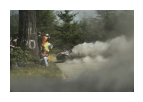

Request: two black dogs playing fetch with a red toy
Значение метрики сходства: 0.048


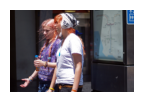

Request: a large bird spreading his wings in flight over a body of water
Значение метрики сходства: 0.066


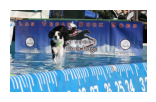

Request: little boy playing basketball in the grass
WARNING! This image is unavailable in your country in compliance with local laws.
 ----------------------------------------------------------------------------------------------------
Request: two boys and a white dog stand in a park
WARNING! This image is unavailable in your country in compliance with local laws.
 ----------------------------------------------------------------------------------------------------
Request: a woman wears a colorful shirt and a lot of jewelry
Значение метрики сходства: 0.081


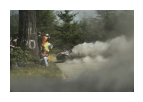

Request: cyclists are leaping into the air whilst being watched by spectators
Значение метрики сходства: 0.171


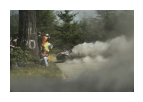

Request: a sad looking dog sitting next to shrubs
Значение метрики сходства: 0.15


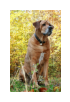

In [32]:
# Получение наиболее вероятных изображений по текстовому описанию
number_request = 10 # Количество случайных запросов, которое необходимо выполнить

for ind in [random.randint(0, 499) for _ in range(number_request)]: # Генерация случайного индекса запроса
    print('Request:', test_queries.loc[ind,'query_text'])
    model_testing_function_(test_queries.loc[ind,'query_text'])

Тестовые данные, содержащие описание, в количестве 500 шт векторизованы с размерностью 768, изображения, в количестве 100 шт, векторизованы с размерностью 1024. Тестовые данные содержат большое количество фотографий детей и нуждаются в фильтрации запросов, таким образом код написан так, что любая попытка ввести запрос, в котором содержатся запрещённые выражения, приводит к выводу предупреждающего сообщения.

Анализируя качество инференса модели приходим к выводу, что модель смогла уловить общие понятия, такие как собака, дети, зима, группа людей и т.д., ровно те объекты, которые часто можно встретить в обучающем наборе данных. Для более тонких понятий как мужчина/женщина и мелких объектов модель непригодна.

## 8. Общие выводы
1. **Исследовательский анализ данных** показал, что данные содержат 1000 уникальных изображений и 977 разнообразных текстовых записей к этим изображениям. Количество описаний у каждого изображения варьируется в диапазоне 1-34.
    - **Исследование распределений оценок экспертов** показывает отличие в распределении оценок у каждого эксперта. Большинство оценок отнесено к негативному классу, меньшинство к позитивному. В 2,7% выборки обнаружено значительное расхождение в оценках между экспертами.
    - **Исследование распределений оценок краудсорсинга** показывает, что основная доля оценок (87,7%) отнесена к негативному классу, так же таблица оценок краудсорсинга содержит большее количество идентификаторов описаний изображений, нежели в экспертном наборе данных.

2. **Проверка данных. ** Набор картинок содержит большое количество изображений детей. По условию задания выпонено удаление запросов, имеющих отношение к детям, таким образом сокращается размер данных, полученных от экспертов, на 27,5%, а данных от краудсорсинга на 30,5%.

3. **Векторизация изображений.** Наиболее подходящие результаты показала модель googlenet, которая формирует относительно небольшое количество значений вектора, равного 1024. Замечено, что модели с большим числом параметров показывают заметно более слабый результат, что, возможно, объясняется малым объёмом данных.

4. **Векторизация текстов.** Для векторизации текстов использована модель deberta-base, формируя относительно небольшое количество значений вектора, равного 768. По аналогии с получением векторов изображений, так же замечено, что модели с большим числом параметров показывают заметно более слабый результат, что, возможно, объясняется малым объёмом данных.

5. **Объединение векторов.** Данные, полученные в ходе экспертных оценок остаются в полном объёме. Данные, полученные с краутсорсинга, имеют большую долю негативных оценок, которые в таком количестве не несут положительной нагрузки, в следствии чего решено использовать возможность сокращения размера данных за счёт снижения их количества на 94%. Одинаковые оценки экспертов и краутсорсинга объединены согласна весовым множителям 0.58 и 0.42.

6. **Обучение модели предсказания соответствия.** Обучены и подобраны гиперпараметры для трёх моделей с использованием метрики RMSE, результаты приведены в сводной таблице:

    | Модели                     | RMSE   | Испытаний | Лучшее испытание |
    | -------------------------- | ------ | --------- | ---------------- |
    | Ridge                      | 0.369  | 200       | 147              |
    | Lasso                      | 0.281  | 500       | 233              |
    | NeuralNetworkModel         | 0.180  | 228       | 184              |
    <p style="text-indent: 40px;">
    Смоделированная полносвязная нейронная сеть показывает лучший результат, уже в среднем на 35 эпохах, можно ожидать целевую метрику RMSE в районе 0.18. Отметим что при длительном обучении сети происходит незначительное увеличение целевой метрики на тестовых данных до 0,20, при том, то модель практически полностью подстраивается под тренировочный набор RMSE=0.02. Возможно данное поведение может свидетельствовать о недостаточном объёме данных, в следствии чего нейронная сеть способно со временем подстраиваться под тестовый набор данных.

7. **Тестирование модели.** Тестовые данные содержат текстовые описания в количестве 500 шт векторизованы с размерностью 768, изображения в количестве 100 шт векторизованы с размерностью 1024. Тестовые данные содержат большое количество фотографий детей, в следствии чего внедрена фильтрации запросов, которые содержат запрещённые выражения.
    <p style="text-indent: 40px;">
    Обучение нейросети на полном объёме данных показал схожую метрику RMSE=0,182, полученную на кросвалидации 0.18. Анализируя качество инференса модели приходим к выводу, что модель смогла уловить общие понятия, такие как собака, дети, зима, группа людей и т.д., ровно те объекты, которые часто можно встретить в обучающем наборе данных. Для более тонких понятий как мужчина/женщина или мелких объектов модель непригодна. 
    <p style="text-indent: 40px;">
    Резюмируя вывод, проект по созданию сервиса поиска фотографий по текстовому описанию практически осуществим, для чего потребуется значительно более разнообразный объём данных и вариантов его описания, а так же потребуется увеличить размер векторов для выявления более тонких соответствий.

## 9. Альтернативное решение

Request: a girl in a bikini top with a great view in the background
Значение метрики сходства лучшего варианта: 0.259


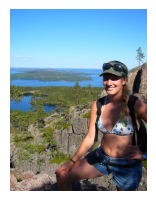

Request: two men are standing under a large work of art by a brick building
Значение метрики сходства лучшего варианта: 0.317


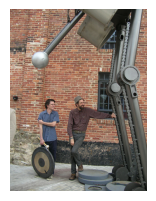

Request: a man sits on the gravel by an ocean
Значение метрики сходства лучшего варианта: 0.254


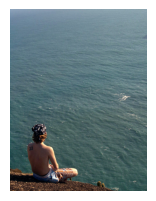

Request: a girl in a bikini top stands in front of a beautiful view
Значение метрики сходства лучшего варианта: 0.272


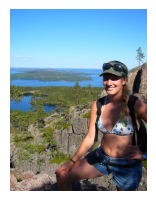

Request: two people jump up and down on a cliff overlooking a valley
Значение метрики сходства лучшего варианта: 0.335


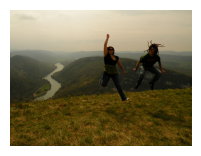

Request: a black dog holding a weight in its mouth stands next to a person
Значение метрики сходства лучшего варианта: 0.338


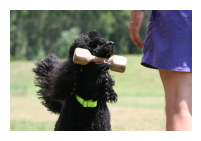

Request: kids in bathing suits with water splashing around them
Значение метрики сходства лучшего варианта: 0.322


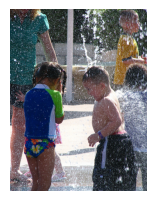

Request: a group of people in a large yard toss a disc
Значение метрики сходства лучшего варианта: 0.27


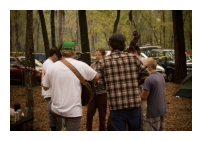

Request: a long-haired brown and white dog carries a snowball in his mouth
Значение метрики сходства лучшего варианта: 0.387


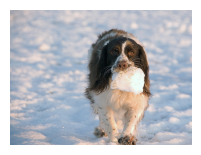

Request: a woman and a young girl riding a sled down a snowy hill while standing
Значение метрики сходства лучшего варианта: 0.294


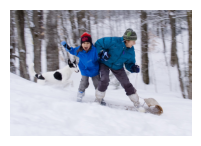

In [66]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer("clip-ViT-B-32")
img_emb = model.encode([Image.open(io.BytesIO(z.open(file).read())).convert('RGB') for file in images], batch_size=10, convert_to_tensor=True)

# Получение наиболее вероятных изображений по текстовому описанию
number_request = 10 # Количество случайных запросов, которое необходимо выполнить

for ind in [random.randint(0, 499) for _ in range(number_request)]: # Генерация случайного индекса запроса
    print('Request:', test_queries.loc[ind,'query_text'])
    text_emb = model.encode(test_queries.loc[ind,'query_text'], convert_to_tensor=True)

    cos_scores = util.semantic_search(text_emb, img_emb, top_k=5)[0] # Вычисление косинусного сходства

    print('Значение метрики сходства лучшего варианта:', np.round(cos_scores[0]['score'],3))

    # Фильтр для подходящих изображений
    filtered_images = [image_file for image_file in images if image_file.split('/')[-1] in name_images_test[cos_scores[0]['corpus_id']]]

    fig = plt.figure(figsize=(10, 10)) # Вывод изображений
    for i, image_file in enumerate(filtered_images):
        image = Image.open(io.BytesIO(z.open(image_file).read()))
        ax = fig.add_subplot(5, 5, i + 1)
        ax.imshow(image)
        ax.axis('off')
    plt.tight_layout()
    plt.show()